# What I learned from investigating “mass reports” of UFO sightings and their explanations (or lack thereof)

R code for the analysis supporting my analysis of mass reports of UFO sightings from the [National UFO Reporting Center (NUFORC)](http://www.nuforc.org/webreports.html). Supporting files are in this GitHub repository. Code for data preparation and cleaning done prior to this are in the .R file, 'datacleaning.R'

In [1]:
library('plyr')
library('dplyr')
library('tidyr')
library('stringr')
library('ggplot2')
library('scales')

ufo <- readRDS('data/ufo.RDS') # UFO sightings dataset, from datacleaning.R 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Number of UFO sightings - total and 2016

This code counts the number of UFO sightings in the entire database and in 2016. 

In [2]:
nrow(ufo)
nrow(ufo %>% filter(event.year == 2016))

[1] 96244

[1] 5194

## UFO sightings by year

Here are UFO sightings according to `event.date`, or the date that the witness said they saw the UFO.

Warning message:
“Removed 1 rows containing missing values (position_stack).”

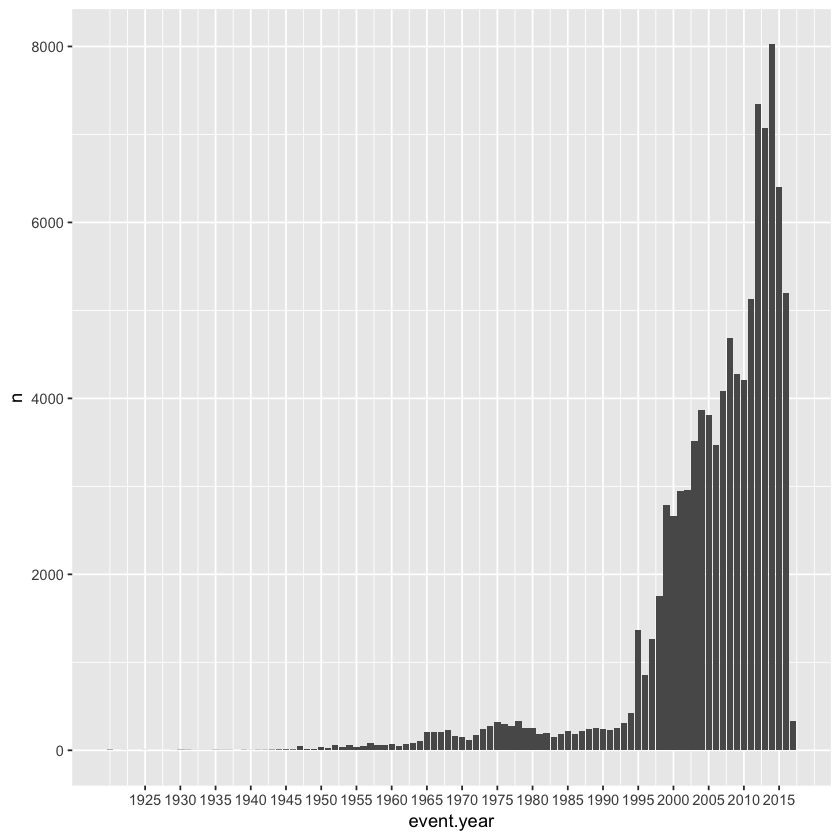

In [3]:
ggplot(ufo %>% group_by(event.year) %>% 
       summarise(n = n()), aes(x = event.year, y = n)) + 
       geom_bar(stat='identity') + scale_x_continuous(breaks = seq(1925, 2017, 5))

The trend may look impressive, but recall that the event date is just the date that the witness *said they saw* the UFO. What may be more interesting is a plot of sightings by `posted.date`, or the date that the witnesss submitted the report to NUFORC.

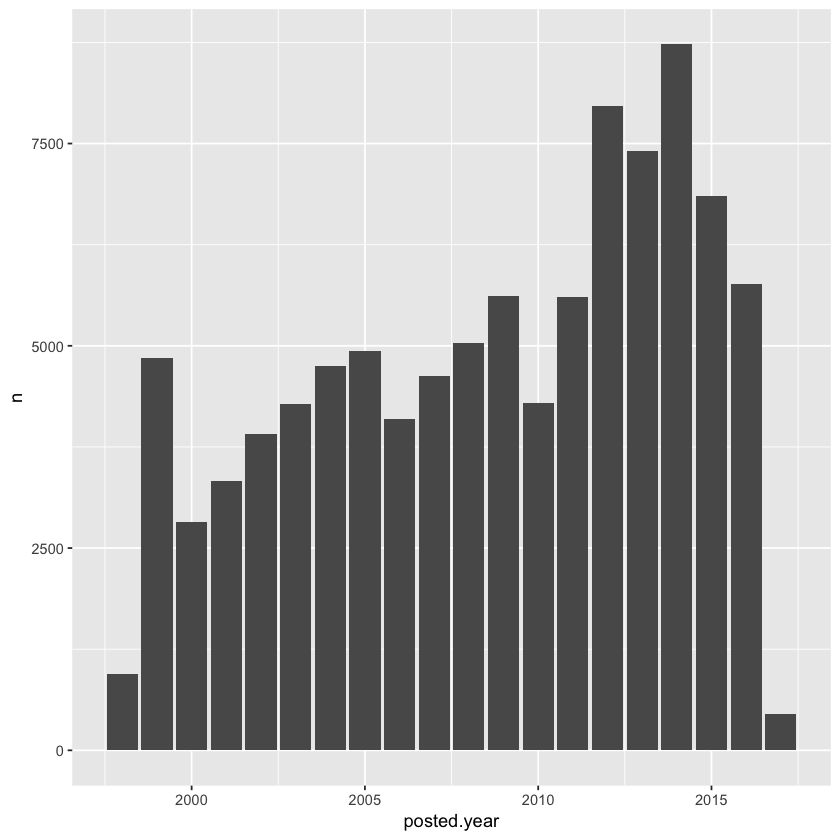

In [4]:
ggplot(ufo %>% group_by(posted.year) %>% 
       summarise(n = n()), aes(x = posted.year, y = n)) + 
       geom_bar(stat='identity')

Restricting the year range on the first graph to 1998 shows a more modest picture, though these trends could be due to a number of factors (increased awareness of UFOs/NUFORC, etc.)

Warning message:
“Removed 72 rows containing missing values (position_stack).”

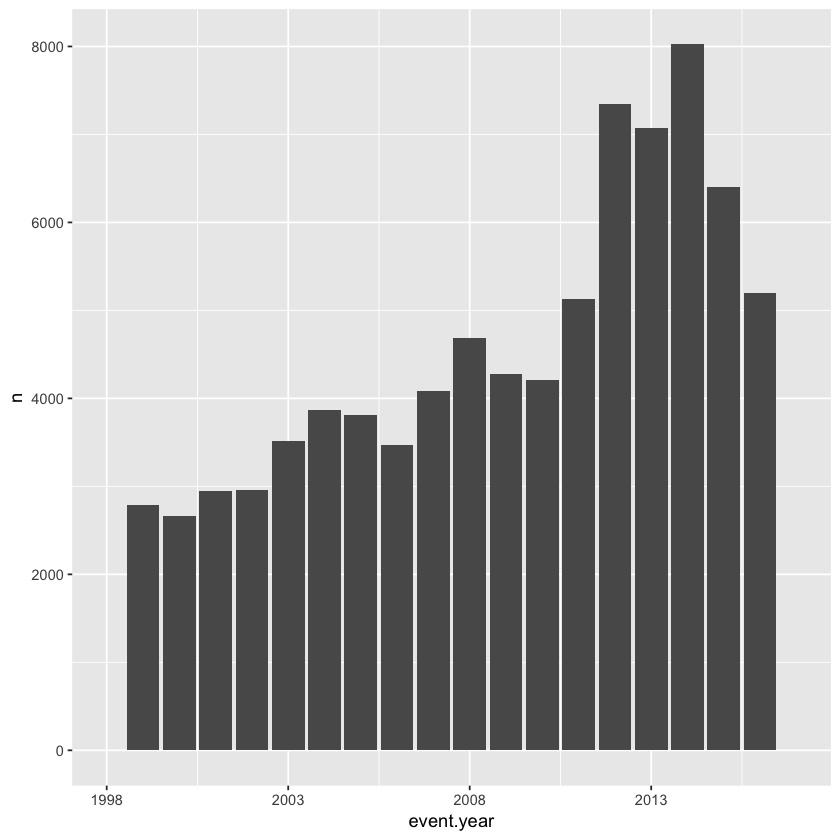

In [5]:
ggplot(ufo %>% group_by(event.year) %>%
       summarise(n = n()), aes(x = event.year, y = n)) + 
       geom_bar(stat='identity') + scale_x_continuous(breaks = seq(1998, 2017, 5), limits = c(1998, 2017))

## Mass reports of UFOs

## Top 10 reported sightings by city and state

This code calculates the locations (city-state pairs) with the highest number of reported UFO sightings in the entire database.

In [6]:
top10.location <- ufo %>% group_by(event.date, city = city.new, state) %>%
  summarise(n = n()) %>%
  arrange(desc(n)) %>%
  head(10)

top10.location

event.date,city,state,n
2004-10-31,Tinley Park,IL,56
2004-08-21,Tinley Park,IL,31
1997-03-13,Phoenix,AZ,29
2001-01-11,Rockford,IL,23
2001-07-15,Carteret,NJ,14
2005-09-30,Tinley Park,IL,12
2001-09-11,New York,NY,10
2003-11-08,New York,NY,10
2005-10-01,Tinley Park,IL,10
2000-02-16,Rockford,IL,9


### Four of the top ten locations for mass sightings are in Tinley Park, Illinois, with 109 reports:

In [7]:
top10.location %>% filter(city == 'Tinley Park') %>% summarise(n = sum(n))

event.date,city,n
2004-08-21,Tinley Park,31
2004-10-31,Tinley Park,56
2005-09-30,Tinley Park,12
2005-10-01,Tinley Park,10


### All witness reports of the "Phoenix Lights" (which occured March 13th, 1997) were submitted at least a year later

The Phoenix Lights were several balls of light [witnessed in the Arizona sky](http://www.azcentral.com/story/news/local/phoenix/2015/02/19/phoenix-lights-arizona-ufo-mystery/23677303/) on March 13th, 1997.

This code subsets the UFO sightings data to get only sightings in Arizona that were reported to have occurred on March 13th, 1997. Arizona is chosen - rather than Phoenix - since lights could have been viewed in neighbording areas. 

There are 39 additional events, bringing the total number of Phoenix Lights witness reports to 68.

In [8]:
ufo$phoenix <- ifelse(ufo$state == 'AZ' & ufo$event.date == '1997-03-13', 1, 0)

table(ufo$phoenix)


    0     1 
96175    68 

Calculating the difference in years between the posted date -- when the sighting was submitted to NUFORC -- to the event date -- when the sighting was said to have occurred (in this case, March 13th, 1997) reveals an interesting finding. Every single report of the Phoenix Lights was submitted at least one year after the actual event itself, the first being in 1997 and the last in 2017.

In [9]:
phoenix <- ufo %>% filter(phoenix == 1) %>% 
  group_by(posted.date, event.date) %>% summarise(n=n()) %>% 
  ungroup() %>% 
  mutate(prop = n / sum(n)) %>%
  arrange(posted.date)

phoenix %>% head(1) 
phoenix %>% tail(1)

phoenix$diffyrs <- as.numeric(round(difftime(phoenix$posted.date, phoenix$event.date)/365.242))

summary(phoenix$diffyrs)

posted.date,event.date,n,prop
1998-03-07,1997-03-13,11,0.1617647


posted.date,event.date,n,prop
2017-01-19,1997-03-13,1,0.01470588


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   4.750   8.000   8.675  11.000  20.000 

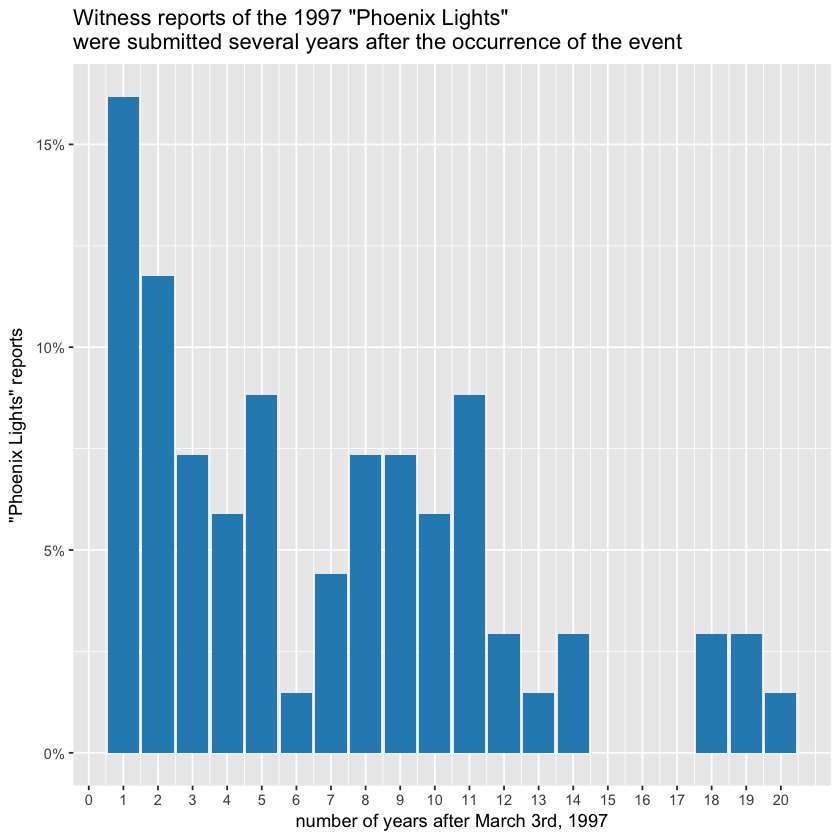

In [10]:
phoenix.plot <- ggplot(phoenix, aes(x = diffyrs, y = prop)) + 
  geom_bar(stat = 'identity', fill = '#2b8cbe') +
  scale_y_continuous(labels = percent) +
  scale_x_continuous(breaks = seq(0, 20, 1)) +
  labs(x = 'number of years after March 3rd, 1997', y = '"Phoenix Lights" reports') +
  ggtitle('Witness reports of the 1997 "Phoenix Lights"\nwere submitted several years after the occurrence of the event')
  
print(phoenix.plot)
ggsave('plots/phoenix.png', phoenix.plot, width = 8, height = 5)  

### 9/11 sightings in New York City

A similar calculation for the reports of UFO sightings on September 11th in NYC reveals that half of them (five out of ten) were submitted after 2001.

In [11]:
sept11 <- ufo %>% filter(event.date == '2001-09-11' & city.new == 'New York') %>% 
  group_by(posted.date, event.date) %>% summarise(n=n())

sept11$diffyrs <- as.numeric(round(difftime(sept11$posted.date, sept11$event.date)/365.242))

sept11 %>% as.data.frame()

sept11 <- ufo %>% filter(event.date == '2001-09-11') %>% 
  group_by(posted.date, event.date) %>% summarise(n = n())

sept11$diffyrs <- as.numeric(round(difftime(sept11$posted.date, sept11$event.date)/365.242))

sum(sept11[sept11$diffyrs > 0,]$n/sum(sept11$n))


posted.date,event.date,n,diffyrs
2001-10-12,2001-09-11,5,0
2002-05-14,2001-09-11,1,1
2007-02-01,2001-09-11,1,5
2008-03-31,2001-09-11,1,7
2009-03-19,2001-09-11,1,8
2012-05-13,2001-09-11,1,11


[1] 0.4390244

Doing the same thing for reported 9/11 sightings nationwide reveals that 43% of them came after 2001.

In [12]:
sept11 <- ufo %>% filter(event.date == '2001-09-11') %>% 
  group_by(posted.date, event.date) %>% summarise(n=n())

sept11$diffyrs <- as.numeric(round(difftime(sept11$posted.date, sept11$event.date)/365.242))

sept11 <- ufo %>% filter(event.date == '2001-09-11') %>% 
  group_by(posted.date, event.date) %>% summarise(n = n())

sept11$diffyrs <- as.numeric(round(difftime(sept11$posted.date, sept11$event.date)/365.242))

sum(sept11[sept11$diffyrs > 0,]$n/sum(sept11$n))

[1] 0.4390244

## Top 10 reported sightings by date

In [13]:
top10.date <- ufo %>% filter(is.na(event.date) == F) %>% 
  group_by(event.date) %>%
  summarise(n = n()) %>%
  arrange(desc(n))  %>%
  head(10)

top10.date

event.date,n
2015-11-07,287
2014-07-04,266
2010-07-04,206
2012-07-04,192
1999-11-16,187
2013-07-04,178
2015-07-04,172
2011-07-04,155
2009-09-19,124
2016-07-27,102


### Six of the ten are on the Fourth of July

This code produces a graph of reported UFO sightings from 1995 (when the current NUFORC director, Peter Davenport took over) to February 10, 2017, with July 4th and New Year's Eve/Day highlighted.

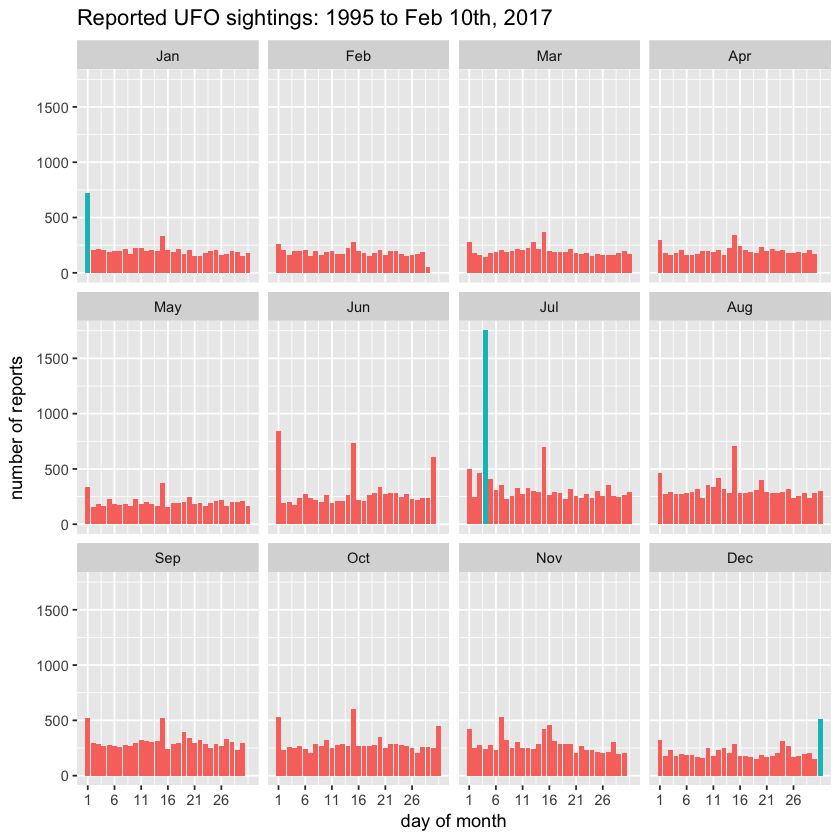

In [14]:
ufo.dates <- ufo %>% filter(is.na(event.date) == F & event.date >= 1995) %>%
  group_by(event.day, event.month) %>%
  summarise(n = n())

ufo.dates$holiday <- ifelse((ufo.dates$event.day == '04' & ufo.dates$event.month == 'Jul') | 
                        (ufo.dates$event.day == '31' & ufo.dates$event.month == 'Dec') |
                        (ufo.dates$event.day == '01' & ufo.dates$event.month == 'Jan'), 1, 0
                      )

ufo.holidays <- ggplot(ufo.dates, aes(x = as.numeric(event.day), y = n, fill = factor(holiday))) +
  geom_bar(stat = 'identity') +
  facet_wrap(~event.month) +
  scale_x_continuous(labels = seq(1, 30, 5), breaks = seq(1, 30, 5)) +
  labs(x = 'day of month', y = 'number of reports') +
  theme(legend.position = 'none') + 
  ggtitle('Reported UFO sightings: 1995 to Feb 10th, 2017') 

print(ufo.holidays)

ggsave('plots/ufo_holidays.png', ufo.holidays, width = 8, height = 6)

The plot above also shows spikes on the 15th  and 1st of each month. Actually, these are the top days of the month for reported UFO sightings.

The 15th is likely an anomaly due to imprecise dates being coded as the 15th.

### Top 5 Days of the month for UFO sightings

In [15]:
ufo %>% group_by(event.day) %>% summarise(n = n()) %>% arrange(desc(n)) %>% head(5)

event.day,n
15,6520
01,6266
04,4067
20,3482
10,3314


### Fireball in the Midwest on November 16, 1999 

The following code illustrates an outlier in the year of 1999 - November 16th, when an object often described as a ["fireball"](https://science.nasa.gov/science-news/science-at-nasa/1999/ast17nov99_1) was reported as passing through the U.S. -- mostly in Midwest areas.

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

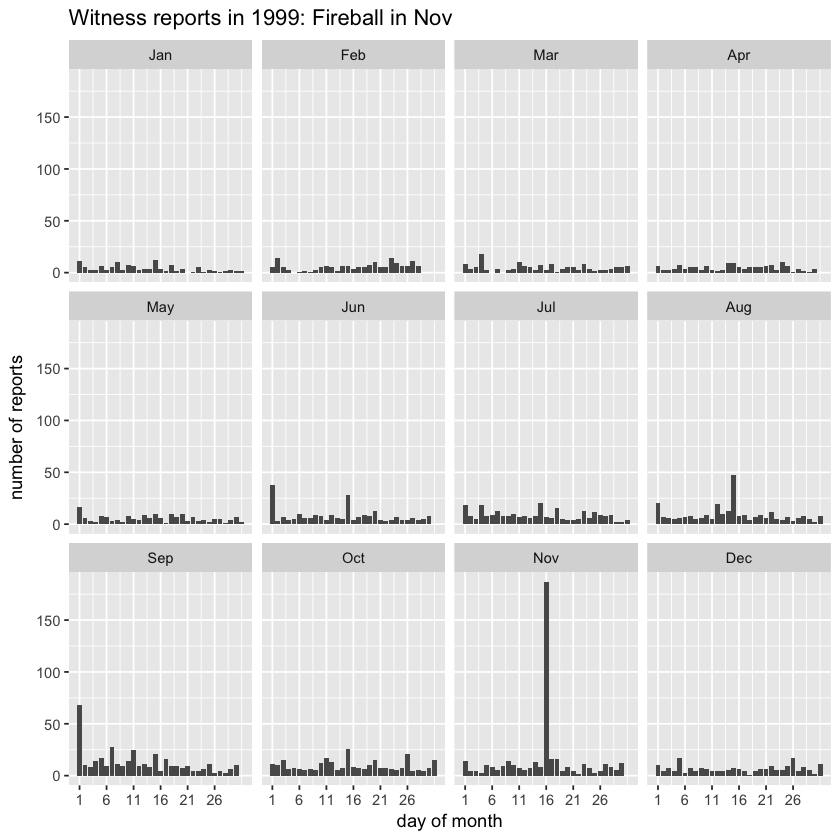

In [16]:
fireball.1999 <- ggplot(ufo %>% filter(event.year == 1999), aes(x = as.numeric(event.day), group = event.month)) +
  geom_histogram(stat = 'count') +
  facet_wrap(~event.month) +
  ggtitle('Witness reports in 1999: Fireball in Nov') +
  scale_x_continuous(breaks = seq(1, 30, 5)) +
  labs(x = 'day of month', y = 'number of reports')

print(fireball.1999)

ggsave('plots/fireball1999.png', fireball.1999, width = 8, height = 5) 

In [17]:
ufo %>% filter(event.date == '1999-11-16') %>% group_by(region) %>% summarise(n = n()) %>% arrange(desc(n))

region,n
Midwest,137
South,28
Northeast,11
West,11


In [18]:
ufo %>% filter(event.date == '1999-11-16') %>% group_by(shape) %>% summarise(n = n()) %>% arrange(desc(n)) %>% head()

shape,n
Fireball,77
Light,22
Formation,18
Other,12
Circle,10
,6


### Missile Launch (?) on September 19th, 2009?

The 93 of the 124 UFO sightings on September 19th, 2009 were marked by NUFORC as "missile launches" in their notes.

In [22]:
ufo %>% filter(event.date == '2009-09-19') %>% group_by(notes) %>% summarise(n = n())

notes,n
Missile launch.,93
NA,31
